# New Section

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import re
import pandas as pd
import sqlite3
from joblib import Parallel, delayed

# STEP 1 Set the file paths

# This is the input text file containing all resumes
input_txt = "/content/drive/MyDrive/Dataset.txt"

# This CSV file will store the extracted category and resume text
output_csv = "/content/drive/MyDrive/clean_resumes_category_text.csv"

In [140]:
# STEP 2 Read the dataset and print the first 500 characters for a quick preview
with open(input_txt, "r", encoding="utf-8", errors="ignore") as f:
    raw_text = f.read()

print(raw_text[:500])

Category,Text
Accountant,"﻿________________

EDUCATION
OMBA - Executive Leadership University of Texas
2016-2018
O Bachelor of Science in Accounting Richland College
2005-2008
TRAINING & CERTIFICATIONS
Certified Management Accountant (CMA)
Certified Financial Modeling and Valuation Analyst
Compliance and Anti-Money Laundering (09/2016) American Institute of Banking
Certified Public Account (CPA)
Lean Six Sigma Green Belt Certified
Trade Products Financial Regulations (08/2016) American Institute


In [141]:
# STEP 3 EXTRACT RESUMES → CSV
resumes = []
current_category = None
current_text = []

# Pattern like: Accountant,"______
category_pattern = re.compile(r'^([A-Za-z ]+),"\ufeff?_{2,}')

with open(input_txt, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        stripped = line.strip()

        match = category_pattern.match(stripped)
        if match:
            # Save previous resume
            if current_category and current_text:
                resumes.append([current_category, " ".join(current_text).strip()])

            # Start new resume
            current_category = match.group(1).strip()
            current_text = []

        else:
            if stripped:
                current_text.append(stripped)

# Save the last resume
if current_category and current_text:
    resumes.append([current_category, " ".join(current_text).strip()])

# Create DataFrame and Export
df = pd.DataFrame(resumes, columns=["Category", "raw_text"])
df.to_csv(output_csv, index=False)

print("Extracted resumes:", len(df))
print(df.head())


Extracted resumes: 13385
     Category                                           raw_text
0  Accountant  EDUCATION OMBA - Executive Leadership Universi...
1  Accountant  HOWARD GERRARD Accountant Deyjob.com, Birmingh...
2  Accountant  Kevin Frank SENIOR ACCOUNTANT info@resumekraft...
3  Accountant  Place of birth Nationality Olivia Ogilvy, Acco...
4  Accountant  Stephen Greet, CPA Senior Accountant Through m...


In [142]:
# STEP 4 This function cleans the resume text by removing unwanted symbols,
# fixing broken unicode characters, deleting emojis, removing HTML tags,
# normalizing spacing, and making the text easier to process.
def clean_resume_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Remove BOM + private unicode + control chars
    text = re.sub(r"[\ufeff\ue000-\uf8ff]", " ", text)  # BOM + PUA unicode
    text = re.sub(r"[\x00-\x1F\x7F]", " ", text)        # control chars

    # 2. Fix broken unicode (common mojibake)
    replacements = {
        "â€¢": "•",
        "â€“": "-",
        "â€”": "-",
        "â€˜": "'",
        "â€™": "'",
        "â€œ": '"',
        "â€": '"',
        "Â©": "",
        "Â®": "",
        "Â": "",
        "â€": "",
        "â€‹": "",
        "â€˜": "'",
        "âš«": "•",
        "â–": "",
        "\uf0b7": "•",
        "\uf0d8": "",
        "\uf0fc": "",
    }
    for bad, good in replacements.items():
        text = text.replace(bad, good)

    # 3. Remove emojis & symbols
    emoji_pattern = r"[\U0001F600-\U0001F64F" \
                    r"\U0001F300-\U0001F5FF" \
                    r"\U0001F680-\U0001F6FF" \
                    r"\U0001F1E0-\U0001F1FF" \
                    r"\u2600-\u26FF\u2700-\u27BF]"
    text = re.sub(emoji_pattern, " ", text)

    # 4. Remove HTML tags & entities
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"&[a-zA-Z]+;", " ", text)

    # 5. Remove non-ASCII leftover junk
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # 6. Normalize bullets & dashes
    text = re.sub(r"[•●▪◆■]", " • ", text)
    text = re.sub(r"_+", " ", text)
    text = re.sub(r"-{3,}", " ", text)

    # 7. Remove problematic symbols
    text = re.sub(r"[~^%$={}<>|`]", " ", text)
    text = re.sub(r"[\/\\]{2,}", " ", text)

    # 8. Collapse punctuation
    text = re.sub(r"\.{2,}", ".", text)
    text = re.sub(r"\,+", ",", text)
    text = re.sub(r"\!{2,}", "!", text)
    text = re.sub(r"\?{2,}", "?", text)

    # 9. Normalize spacing
    text = re.sub(r"\s+", " ", text)

    return text.strip()

In [143]:
# STEP 5 Load the extracted 2-column CSV (Category, raw_text)
df = pd.read_csv(output_csv, encoding="utf-8")

# Apply the cleaning function to each resume and store the cleaned text
df["clean_text"] = df["raw_text"].apply(clean_resume_text)


In [144]:
# Step 6 Name extractor pattern and function
NAME_RE = re.compile(r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b')

def extract_name(text):
    """Find first capitalized word pair on early lines"""
    lines = text.split("\n")
    for line in lines[:5]:
        m = NAME_RE.search(line)
        if m:
            return m.group(1)
    return None

In [145]:
# Step 7 Email extraction regex
EMAIL_RE = re.compile(
    r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[A-Za-z]{2,}",
    re.IGNORECASE
)
def extract_email(text):
    """
    Extract the first valid email from any unstructured resume text.
    Returns None if no email found.
    """
    if not isinstance(text, str):
        return None

    match = EMAIL_RE.search(text)
    if match:
        return match.group(0).strip()

    return None

In [146]:
# Step 8 Extract phone numbers using a strong international phone regex
# This step removes years, year ranges, and date formats so only real phone numbers are captured.
import re

# Strong international phone number regex
PHONE_RE = re.compile(
    r"""
    (?<!\d)
    (?:\+?\d{1,3}[\s\-\.]?)?
    (?:\(?\d{2,4}\)?[\s\-\.]?)?
    \d{3,4}[\s\-\.]?\d{3,4}
    (?!\d)
    """,
    re.VERBOSE
)

def extract_phone(text):
    """
    Extract real international phone numbers.
    Rejects:
    - years (2016, 2018)
    - year ranges (2016-2018)
    - dates (03/2019)
    - numbers with <7 digits total
    """
    if not isinstance(text, str):
        return None

    # Remove year ranges
    text = re.sub(r"\b(19|20)\d{2}\s*[-–]\s*(19|20)\d{2}\b", " ", text)

    # Remove standalone years
    text = re.sub(r"\b(19|20)\d{2}\b", " ", text)

    # Remove dates like 08/2019
    text = re.sub(r"\b\d{1,2}[/\-]\d{4}\b", " ", text)

    # Search for phone numbers
    matches = PHONE_RE.findall(text)

    for m in matches:
        cleaned = re.sub(r"[^\d+]", "", m)
        digits_only = re.sub(r"\D", "", cleaned)

        if 7 <= len(digits_only) <= 15:
            return cleaned

    return None

In [147]:
# STEP 9 Extract skills from resume text

def clean_skill_section(sec):
    """Clean the skill section by removing headers, broken bullets, and extra symbols"""
    if not sec:
        return ""

    # Remove section headers like 'Skills', 'Technical Skills', etc.
    sec = re.sub(r"(?i)^.*skills.*?:?", "", sec).strip()

    # Remove broken bullet characters (O, D, □)
    sec = re.sub(r"\b[OD□]+\b", " ", sec)

    # Remove other common bullet symbols
    sec = re.sub(r"[•·●▪■□◆◇]", " ", sec)

    # Replace & with space
    sec = sec.replace("&", " ")

    # Collapse multiple spaces into one
    sec = re.sub(r"\s+", " ", sec)

    return sec.strip()

# List of common section headers to help locate skills or other sections
SECTION_HEADERS = [
    "skills", "technical skills", "core skills", "key skills", "professional skills",
    "experience", "work experience", "professional experience", "employment",
    "education", "academic background", "qualifications",
    "certifications", "licenses",
    "projects", "achievements", "accomplishments",
    "summary", "profile", "objective",
    "languages", "interests"
]

def extract_section(text, section_name):
    """Extract a section from the resume text based on a given header"""
    t = text.lower()
    m = re.search(r"\b" + re.escape(section_name.lower()) + r"\b", t)
    if not m:
        return ""

    start = m.start()

    # Find the start of the next section to know where this section ends
    next_positions = []
    for sec in SECTION_HEADERS:
        if sec == section_name.lower():
            continue
        m2 = re.search(r"\b" + re.escape(sec) + r"\b", t[start+1:])
        if m2:
            next_positions.append(start + 1 + m2.start())

    # Section ends at the start of the next section or end of text
    end = min(next_positions) if next_positions else len(text)
    return text[start:end]

def get_skills_section(text):
    """Locate the skills section using common skill-related headers"""
    skill_headers = [
        "skills", "technical skills", "core skills",
        "professional skills", "key skills", "expertise",
        "competencies", "core competencies", "highlights"
    ]
    for h in skill_headers:
        sec = extract_section(text, h)
        if sec:
            return sec
    return ""

def split_into_skills(section):
    """Split the skills section into individual skill items"""
    if not section:
        return []

    # Clean the section first
    section = clean_skill_section(section)

    # Remove broken bullets again just in case
    section = re.sub(r"\b[OD□]+\b", " ", section)

    # Normalize & and remove bullet symbols
    section = section.replace("&", " and ")
    section = re.sub(r"[•·●▪■□◆◇]", " ", section)

    # Collapse multiple spaces
    section = re.sub(r"\s+", " ", section).strip()

    # Split before each new capitalized phrase (e.g., "General Ledger GAAP Standards")
    chunks = re.split(r" (?=[A-Z][a-zA-Z])", section)

    skills = []

    for c in chunks:
        c = c.strip()
        if len(c) < 3:
            continue

        # Remove unwanted characters
        c = re.sub(r"[^a-zA-Z0-9+()\/& ]", " ", c)
        c = re.sub(r"\s+", " ", c).strip()

        # Split further on double-capital words (avoid merging skills)
        subskills = re.split(r" (?=[A-Z]{2,})", c)

        for sk in subskills:
            sk = sk.strip()
            if len(sk) > 2 and sk not in skills:
                skills.append(sk)

    return skills

def extract_universal_skills(text):
    """Main function to get all skills from a resume"""
    sec = get_skills_section(text)
    if not sec:
        return []
    return split_into_skills(sec)


In [148]:
# Step 10-------- EXPERIENCE --------
def extract_experience(text):
    m = re.search(r"(\d+)\+?\s+(?:years?|yrs?)", text, re.I)
    return int(m.group(1)) if m else 0


In [149]:
# STEP 11 Education extractor functions
# These functions locate the education section in a resume and extract degree/institute/year entries

def get_education_section(text):
    """Locate the education section in the resume text"""

    # Normalize text to lowercase for easier matching
    t = text.lower()

    # Section headers that may appear after education
    stop_sections = [
        "experience", "work experience", "professional experience",
        "training", "certifications", "projects", "technical",
        "skills", "achievements", "languages", "interests",
        "summary", "profile"
    ]

    # Find the start of the education section
    edu_start = re.search(r"\beducation\b", t)
    if not edu_start:
        return ""  # no education section found

    start_index = edu_start.start()

    # Find the start index of the next section to know where education ends
    next_indices = []
    for sec in stop_sections:
        m = re.search(r"\b" + sec + r"\b", t[edu_start.end():])
        if m:
            next_indices.append(edu_start.end() + m.start())

    # End index of education section
    end_index = min(next_indices) if next_indices else len(text)

    # Return the education section text
    return text[start_index:end_index].strip()


def extract_education_entries(edu_text):
    """Extract individual education entries (degree, institute, year) from the education section"""

    # Degree patterns to look for
    DEGREE = r"(?:MBA|B\.?Sc|M\.?Sc|B\.?A|M\.?A|B\.?Tech|M\.?Tech|B\.?Com|M\.?Com|Bachelor|Master|Ph\.?D|Diploma)"

    # Institute keywords
    INSTITUTE = r"(?:University|College|Institute|School)"

    # Year pattern
    YEAR = r"(?:19|20)\d{2}"

    # Patterns to match common education formats
    patterns = [
        rf"{DEGREE}[^.\n]{{0,150}}{INSTITUTE}[^.\n]{{0,100}}{YEAR}",  # Degree + University + Year
        rf"{DEGREE}[^.\n]{{0,200}}{YEAR}",                             # Degree + Year
        rf"{DEGREE}[^.\n]{{0,200}}",                                   # Degree only
        rf"{INSTITUTE}[^.\n]{{0,200}}{YEAR}",                          # University + Year
    ]

    results = []

    # Search for matches using all patterns
    for pat in patterns:
        matches = re.findall(pat, edu_text, flags=re.I)
        for m in matches:
            entry = m.strip()
            # Keep only entries that are reasonably long
            if len(entry) > 8:
                results.append(entry)

    # Remove duplicates and normalize spacing
    clean = []
    for r in results:
        r = re.sub(r"\s+", " ", r)
        if r not in clean:
            clean.append(r)

    return clean


def extract_education_universal(text):
    """Main function to extract all education entries from a resume"""
    edu_section = get_education_section(text)
    if not edu_section:
        return []
    return extract_education_entries(edu_section)


In [150]:
# STEP 12 Apply extraction logic to the cleaned resume data

# Ensure the text column is named 'raw_text' for consistency
df = df.rename(columns={"Text": "raw_text"})

# Assign a unique ID to each resume
df["resume_id"] = range(1, len(df) + 1)

# Extract emails from each cleaned resume text
df["email"] = df["clean_text"].apply(extract_email)

# Extract phone numbers from each cleaned resume text
df["phone"] = df["clean_text"].apply(extract_phone)

# Extract skills from each cleaned resume text
df["skills"] = df["clean_text"].apply(extract_universal_skills)

# Extract years of experience from each cleaned resume text
df["experience_years"] = df["clean_text"].apply(extract_experience)

# Extract education details (degrees, institutes, years) from each cleaned resume text
df["education"] = df["clean_text"].apply(extract_education_universal)


In [151]:
# STEP 13 Extract all fields from each resume and prepare final dataframe

def extract_all_fields(text, resume_id):
    """
    Extract all relevant fields from a resume text:
    - Clean the text first
    - Extract email, phone, skills, experience, and education
    - Return as a dictionary with resume_id
    """
    text = clean_text_basic(text)  # Basic cleaning before extraction

    return {
        "resume_id": resume_id,
        "email": extract_email(text),
        "phone": extract_phone(text),
        "skills": extract_skills(text),
        "experience_years": extract_experience(text),
        "education": extract_education(text)
    }

# Remove intermediate columns that are no longer needed
df = df.drop(columns=["raw_text", "clean_text"], errors="ignore")

# Reorder columns to have resume_id first, followed by category and extracted fields
df = df[[
    "resume_id",
    "Category",
    "email",
    "phone",
    "skills",
    "experience_years",
    "education"
]]

# Display first few rows of the final dataframe
df.head()


,resume_id,Category,email,phone,skills,experience_years,education
0,1,Accountant,None,None,"[Quickbooks, ERP (SAP, Oracle), Hyperion]",0,[MBA - Executive Leadership University of Texa...
1,2,Accountant,info@dayjob.com,01234567890,"[Course details, Accounts, English (A), Maths ...",0,[Managing the receipts and deposits of cash an...
2,3,Accountant,info@resumekraft.com,2025550120,"[Documentation, Poised under pressure, Hobbies...",0,[Bachelor Of Commerce San Jose State Universit...
3,4,Accountant,email@email.com,None,[],7,"[Management & Research (AIMR), Chartered Finan..."
4,5,Accountant,stephen@beamjobs.com,1234567890,"[QuickBooks, Taxjar, GAAP accounting principle...",9,"[MBA Accounting 2012 Pittsburgh, PA Certified ..."


In [152]:
# SAVE FINAL OUTPUT CSV
output_csv = "/content/drive/MyDrive/Resume_final_output.csv"

df.to_csv(output_csv, index=False, encoding="utf-8")

print("Saved CSV to:", output_csv)


Saved CSV to: /content/drive/MyDrive/Resume_final_output.csv


Processes each resume in parallel

In [153]:
# STEP 14 Load cleaned resumes CSV, assign IDs, and clean text

# Read the CSV file containing extracted resumes
df = pd.read_csv("/content/drive/MyDrive/clean_resumes_category_text.csv")

# Ensure the text column is consistently named 'raw_text'
if 'Text' in df.columns:
    df = df.rename(columns={'Text': 'raw_text'})

# Assign a unique ID to each resume for tracking
df["resume_id"] = range(1, len(df) + 1)

# Apply the text cleaning function to prepare clean_text for further extraction
df["clean_text"] = df["raw_text"].apply(clean_resume_text)

In [154]:
# STEP 15 Parallel extraction of all fields from cleaned resumes

import concurrent.futures

def extract_all_fields_parallel(row):
    """
    Extract all key fields from a single resume row in parallel:
    - Uses cleaned text from 'clean_text' column
    - Extracts email, phone, skills, experience, and education
    - Returns a dictionary with resume_id, Category, and extracted fields
    """
    text = row["clean_text"]
    resume_id = row["resume_id"]
    category = row["Category"]

    return {
        "resume_id": resume_id,
        "Category": category,
        "email": extract_email(text),
        "phone": extract_phone(text),
        "skills": extract_universal_skills(text),
        "experience_years": extract_experience(text),
        "education": extract_education_universal(text)
    }

In [155]:
# STEP 16 Execute parallel extraction and create final structured dataframe

import concurrent.futures
import pandas as pd

# List to hold the processed results (optional, here we directly collect results)
processed_rows = []

# Use ThreadPoolExecutor to process resumes in parallel for faster execution
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    # Map the extraction function to all rows of the dataframe
    results = list(executor.map(extract_all_fields_parallel, df.to_dict("records")))

# Convert the list of dictionaries returned by parallel extraction into a final DataFrame
final_df = pd.DataFrame(results)

In [156]:
# Save the final structured dataframe to CSV
final_df.to_csv("/content/drive/MyDrive/resume_final_parallel.csv", index=False)
print("Saved!")


Saved!


Store the Final Output in SQLite Database

In [157]:
# STEP 17 Set up SQLite database connection

import sqlite3
import json

# Path to the SQLite database file (will be created if it doesn't exist)
db_path = "/content/drive/MyDrive/resume_database.db"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# At this point, you can create tables and insert your processed resume data

In [158]:
# STEP 18 Create resumes table in the SQLite database

cursor.execute("""
CREATE TABLE IF NOT EXISTS resumes (
    resume_id INTEGER PRIMARY KEY,   -- Unique ID for each resume
    category TEXT,                   -- Resume category/job title
    email TEXT,                      -- Extracted email
    phone TEXT,                      -- Extracted phone number
    skills TEXT,                     -- Extracted skills (will store as JSON string)
    experience_years INTEGER,        -- Extracted years of experience
    education TEXT                   -- Extracted education details (will store as JSON string)
)
""")

# Commit the changes to save the table structure in the database
conn.commit()

In [159]:
# STEP 19 Insert processed resume data into the SQLite database

# Convert list-type columns to JSON strings so they can be stored in TEXT fields
final_df['skills'] = final_df['skills'].apply(json.dumps)
final_df['education'] = final_df['education'].apply(json.dumps)

# Insert the dataframe into the 'resumes' table
# if_exists="replace" will overwrite the table if it already exists
final_df.to_sql("resumes", conn, if_exists="replace", index=False)

# Commit the changes to save data in the database
conn.commit()

# Confirmation message
print("Data inserted into SQLite successfully!")

Data inserted into SQLite successfully!


In [160]:
# STEP 20 Save the final processed resumes to CSV

# Define the output path for the final CSV
final_path = "/content/drive/MyDrive/resume_final_parallel.csv"

# Save the final dataframe to CSV without the index column
final_df.to_csv(final_path, index=False)

# Confirmation message with the saved file path
print("Saved CSV:", final_path)

Saved CSV: /content/drive/MyDrive/resume_final_parallel.csv


Build Visualizations (Charts)

In [161]:
# Import libraries for data visualization

import matplotlib.pyplot as plt   # For creating plots, charts, and figures
import seaborn as sns             # For advanced statistical visualizations with better aesthetics
from collections import Counter   # To count occurrences of items (useful for plotting frequency of skills, categories, etc.)


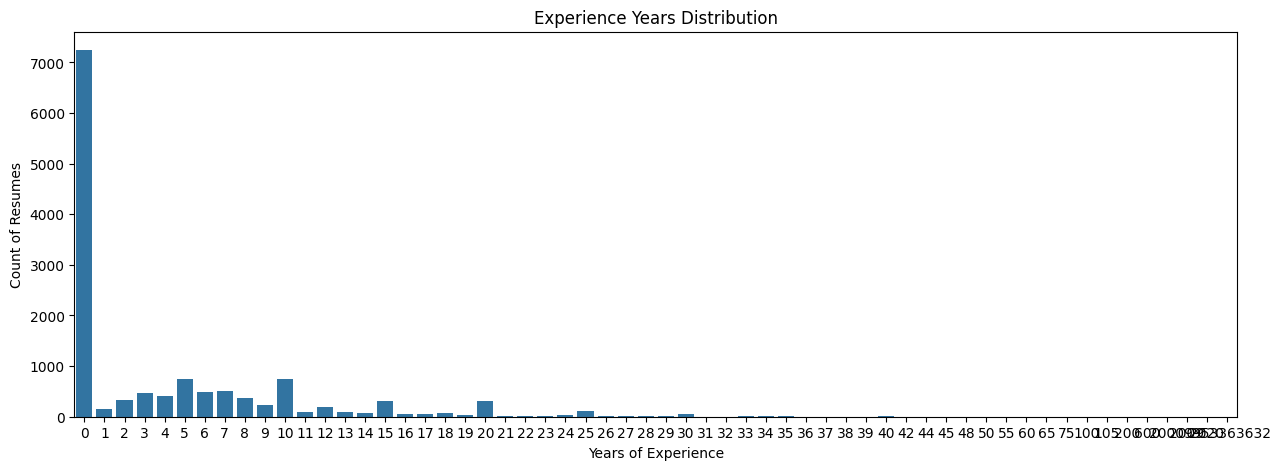

In [162]:
# STEP 21 Plot distribution of years of experience across resumes

plt.figure(figsize=(15, 5))  # Set figure size for better visibility

# Create a count plot to show how many resumes have each number of experience years
sns.countplot(x=final_df["experience_years"])

# Add title and axis labels for clarity
plt.title("Experience Years Distribution")
plt.xlabel("Years of Experience")
plt.ylabel("Count of Resumes")

# Display the plot
plt.show()

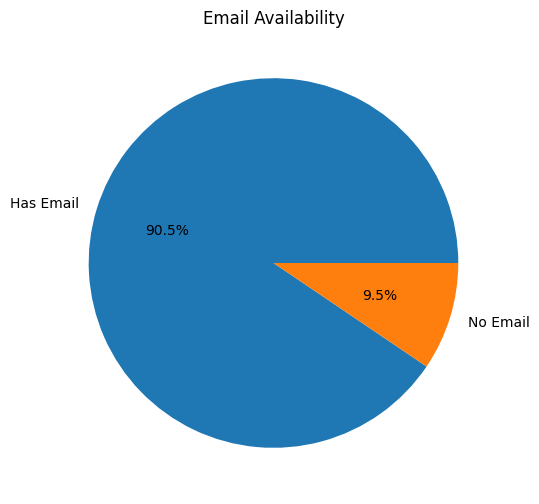

In [163]:
# STEP 23 Visualize email availability in resumes

# Count resumes with and without email
email_count = final_df["email"].notnull().sum()   # Number of resumes with an email
no_email_count = final_df["email"].isnull().sum() # Number of resumes without an email

# Create a pie chart to show the proportion of resumes with and without emails
plt.figure(figsize=(6,6))
plt.pie(
    [email_count, no_email_count],  # Data to plot
    autopct="%1.1f%%",             # Display percentage on the chart
    labels=["Has Email", "No Email"] # Labels for slices
)

# Add title for clarity
plt.title("Email Availability")

# Display the plot
plt.show()

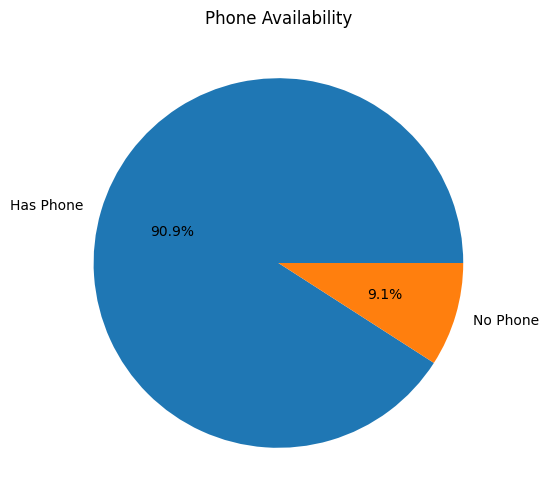

In [164]:
# STEP 24 Visualize phone number availability in resumes

# Count resumes with and without phone numbers
phone_count = final_df["phone"].notnull().sum()    # Number of resumes with a phone number
no_phone_count = final_df["phone"].isnull().sum() # Number of resumes without a phone number

# Create a pie chart to show the proportion of resumes with and without phone numbers
plt.figure(figsize=(6,6))
plt.pie(
    [phone_count, no_phone_count],   # Data to plot
    autopct="%1.1f%%",               # Display percentage on the chart
    labels=["Has Phone", "No Phone"] # Labels for slices
)

# Add title for clarity
plt.title("Phone Availability")

# Display the plot
plt.show()

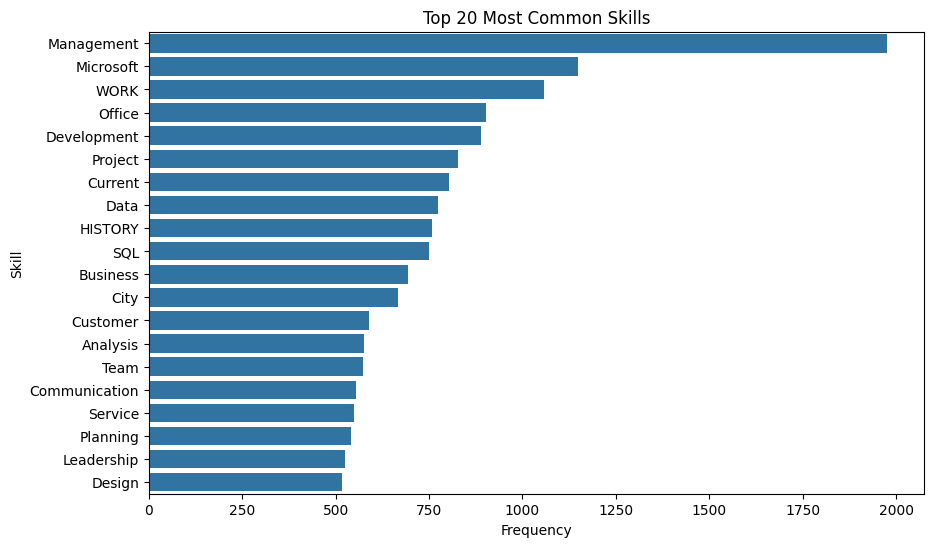

In [165]:
# STEP 25 Visualize the Top 20 most common skills across resumes

all_skills = []

# Loop through the 'skills' column to collect all skills into a single list
for skills_item in final_df["skills"]:
    if isinstance(skills_item, str):  # Check if the skills are stored as JSON strings
        try:
            skill_list = json.loads(skills_item)  # Decode JSON string into a Python list
            if isinstance(skill_list, list):     # Ensure decoding returned a list
                all_skills.extend(skill_list)    # Add skills to the master list
        except json.JSONDecodeError:
            continue  # Skip invalid JSON entries
    elif isinstance(skills_item, list):
        # If the skills are already a list (e.g., before saving to SQLite), extend directly
        all_skills.extend(skills_item)

# Count frequency of each skill and get the top 20
skill_freq = Counter(all_skills).most_common(20)

# Check if there are skills to plot
if skill_freq:
    skills, values = zip(*skill_freq)  # Separate skill names and their frequencies

    # Create a horizontal bar plot for the top 20 skills
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(values), y=list(skills))
    plt.title("Top 20 Most Common Skills")
    plt.xlabel("Frequency")
    plt.ylabel("Skill")
    plt.show()
else:
    # Handle case when no skills are available
    print("No common skills found to display a chart.")
    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Most Common Skills (No skills found)")
    plt.text(
        0.5, 0.5,
        "No skills available for plotting",
        horizontalalignment='center',
        verticalalignment='center',
        transform=plt.gca().transAxes
    )
    plt.show()